# Comprehensive Exadata & Database Resources Analysis

This notebook provides a deep-dive analysis of all Exadata and database infrastructure resources, including cost tracking, capacity analysis, performance metrics, and optimization opportunities.

In [103]:
# Setup and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully")

# Load data from output files
try:
    df = pd.read_csv('../output/2.csv')
    df_trends = pd.read_csv('../output/2.csv')
    print(f"✅ Data loaded successfully")
    print(f"   Main dataset: {df.shape[0]:,} rows x {df.shape[1]} columns")
    print(f"   Trends dataset: {df_trends.shape[0]:,} rows x {df_trends.shape[1]} columns")
except Exception as e:
    print(f"❌ Error loading data: {str(e)}")
    print("   Make sure output_merged.csv and output.csv exist in ../output/")


✅ Libraries imported successfully
✅ Data loaded successfully
   Main dataset: 6,442 rows x 36 columns
   Trends dataset: 6,442 rows x 36 columns


## Section 1: Data Preparation & Exadata/Database Filtering

In [104]:
# Data Preparation and Resource Filtering
print("="*160)
print(" "*50 + "DATA PREPARATION & RESOURCE FILTERING")
print("="*160)

# Convert dates
df['timeUsageStarted'] = pd.to_datetime(df['timeUsageStarted'])
df['timeUsageEnded'] = pd.to_datetime(df['timeUsageEnded'])
df['date'] = df['timeUsageStarted'].dt.date
df['month'] = df['timeUsageStarted'].dt.to_period('M')

# Clean compartment paths
df['compartment_name_clean'] = df['compartmentPath'].fillna('Unknown').str.split('/').str[-1]

# Ensure string columns for filtering
df['service'] = df['service'].fillna('Unknown Service').astype(str)
df['region_from_call2'] = df['region_from_call2'].fillna(df['region']).astype(str)

# Safe string operations with type conversion
for col in ['skuName', 'skuPartNumber', 'resourceName']:
    if col in df.columns:
        df[col] = df[col].fillna('').astype(str)

# ========================================================================================
# FILTER 1: EXADATA RESOURCES
# ========================================================================================
print("\n📊 Filtering Exadata resources...")
filter_exadata = df['service'].str.contains('Exadata', case=False, na=False)

if 'skuName' in df.columns:
    filter_exadata = filter_exadata | df['skuName'].str.contains('Exadata', case=False, na=False)
if 'skuPartNumber' in df.columns:
    filter_exadata = filter_exadata | df['skuPartNumber'].str.contains('Exadata', case=False, na=False)
if 'resourceName' in df.columns:
    filter_exadata = filter_exadata | df['resourceName'].str.contains('Exadata', case=False, na=False)

exadata_df = df[filter_exadata].copy()
print(f"✅ Found {len(exadata_df):,} Exadata records")
print(f"   Total Cost: ${exadata_df['computedAmount'].sum():,.2f}")
print(f"   Unique Systems: {exadata_df['resourceId'].nunique()}")

# ========================================================================================
# FILTER 2: DATABASE RESOURCES
# ========================================================================================
print("\n📊 Filtering Database resources...")
database_keywords = ['Database', 'Autonomous', 'MySQL', 'PostgreSQL', 'NoSQL', 'Oracle DB']
filter_database = df['service'].str.contains('|'.join(database_keywords), case=False, na=False)

database_df = df[filter_database].copy()
print(f"✅ Found {len(database_df):,} Database records")
print(f"   Total Cost: ${database_df['computedAmount'].sum():,.2f}")
print(f"   Unique Databases: {database_df['resourceId'].nunique()}")
print(f"   Database Services: {database_df['service'].nunique()}")

# ========================================================================================
# FILTER 3: COMBINED EXADATA + DATABASE
# ========================================================================================
print("\n📊 Filtering Combined Exadata + Database resources...")
filter_combined = filter_exadata | filter_database
combined_df = df[filter_combined].copy()

print(f"✅ Found {len(combined_df):,} combined Exadata/Database records")
print(f"   Total Cost: ${combined_df['computedAmount'].sum():,.2f}")
print(f"   Percentage of Total Cloud Spend: {(combined_df['computedAmount'].sum() / df['computedAmount'].sum()) * 100:.2f}%")

print("\n" + "="*160)


                                                  DATA PREPARATION & RESOURCE FILTERING

📊 Filtering Exadata resources...
✅ Found 1,318 Exadata records
   Total Cost: $103,933.94
   Unique Systems: 5

📊 Filtering Database resources...
✅ Found 1,318 Database records
   Total Cost: $103,933.94
   Unique Databases: 5
   Database Services: 1

📊 Filtering Combined Exadata + Database resources...
✅ Found 1,318 combined Exadata/Database records
   Total Cost: $103,933.94
   Percentage of Total Cloud Spend: 96.94%



## Section 1.5: Exadata Infrastructure vs CPU Cost Segmentation by Date

                                             EXADATA INFRASTRUCTURE vs CPU COST SEGMENTATION

📊 EXADATA COST SEGMENTATION SUMMARY:
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Category                            Total Cost    % of Exadata              Hours    Resources
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Other                     $          84,658.48           81.5%              6,480          1.0
CPU                       $          19,275.47           18.5%             15,934          4.0

📊 DATABASE COST SEGMENTATION SUMMARY:
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Category                            Total Cost   % of Database

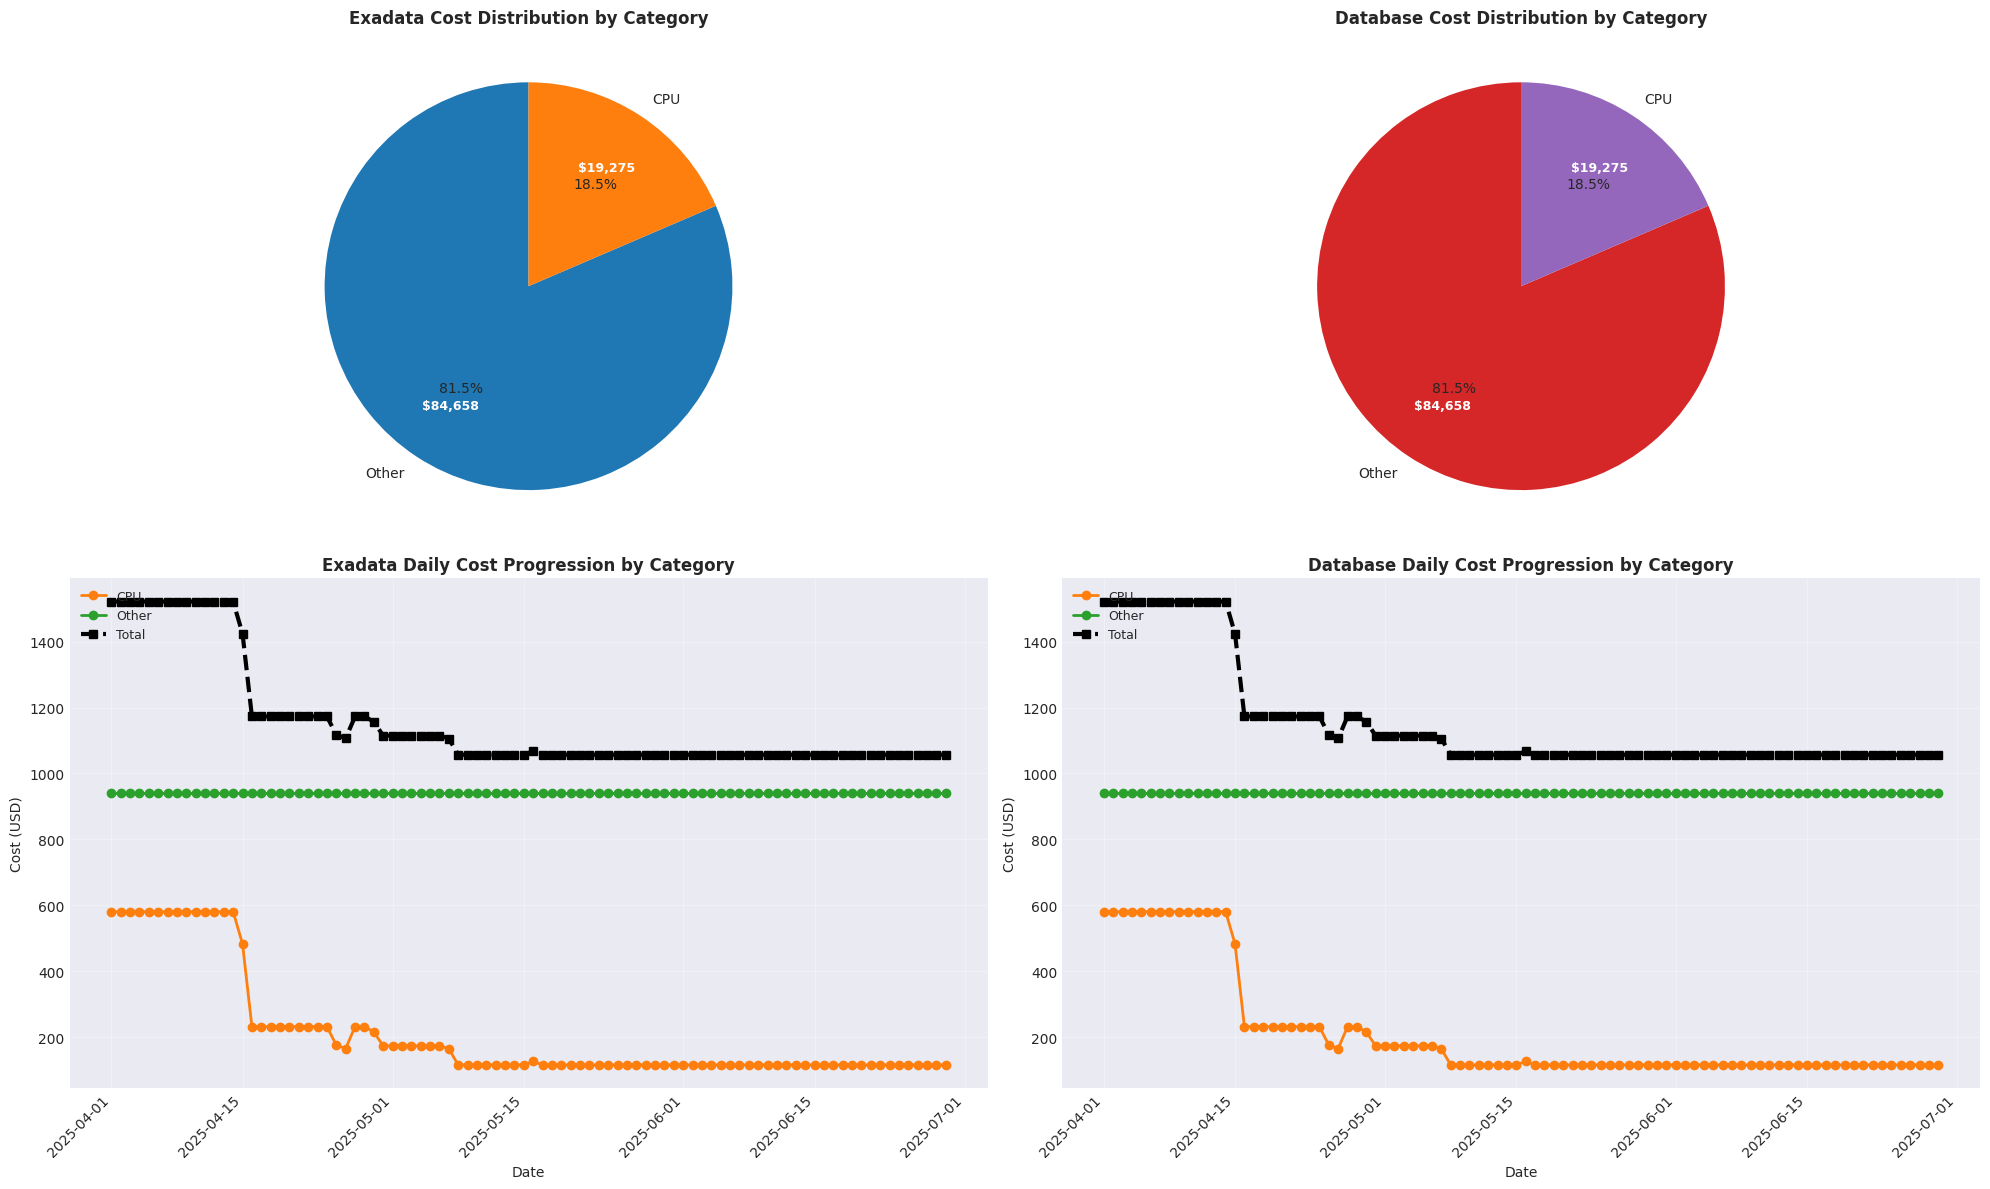

✅ Cost Segmentation Analysis Complete


In [105]:
print("="*160)
print(" "*45 + "EXADATA INFRASTRUCTURE vs CPU COST SEGMENTATION")
print("="*160)
print()

# ============================================================================
# COST SEGMENTATION: Infrastructure vs CPU
# ============================================================================

# Keywords to identify CPU-related costs
cpu_keywords = ['CPU', 'OCPU', 'OCPUs', 'Compute', 'Core', 'vCPU', 'Processor']
infra_keywords = ['Storage', 'Memory', 'Network', 'Backup', 'License', 'Support', 'Infrastructure']

# Create cost category flags
exadata_df['is_cpu'] = False
exadata_df['is_infrastructure'] = False

# Safe string operations for SKU identification
for col in ['skuName', 'skuPartNumber', 'productName', 'description']:
    if col in exadata_df.columns:
        exadata_df_clean_col = exadata_df[col].fillna('').astype(str).str.upper()
        
        # Mark CPU costs
        exadata_df['is_cpu'] = exadata_df['is_cpu'] | exadata_df_clean_col.str.contains('|'.join(cpu_keywords), na=False)
        
        # Mark Infrastructure costs
        exadata_df['is_infrastructure'] = exadata_df['is_infrastructure'] | exadata_df_clean_col.str.contains('|'.join(infra_keywords), na=False)

# Mark remaining as Other/Misc
exadata_df['cost_category'] = 'Other'
exadata_df.loc[exadata_df['is_cpu'], 'cost_category'] = 'CPU'
exadata_df.loc[exadata_df['is_infrastructure'], 'cost_category'] = 'Infrastructure'

# Similarly for Database
database_df['is_cpu'] = False
database_df['is_infrastructure'] = False

for col in ['skuName', 'skuPartNumber', 'productName', 'description']:
    if col in database_df.columns:
        database_df_clean_col = database_df[col].fillna('').astype(str).str.upper()
        database_df['is_cpu'] = database_df['is_cpu'] | database_df_clean_col.str.contains('|'.join(cpu_keywords), na=False)
        database_df['is_infrastructure'] = database_df['is_infrastructure'] | database_df_clean_col.str.contains('|'.join(infra_keywords), na=False)

database_df['cost_category'] = 'Other'
database_df.loc[database_df['is_cpu'], 'cost_category'] = 'CPU'
database_df.loc[database_df['is_infrastructure'], 'cost_category'] = 'Infrastructure'

# ============================================================================
# EXADATA: COST SEGMENTATION SUMMARY
# ============================================================================
print("📊 EXADATA COST SEGMENTATION SUMMARY:")
print("-" * 160)

exadata_segmentation = exadata_df.groupby('cost_category').agg({
    'computedAmount': 'sum',
    'computedQuantity': 'sum',
    'resourceId': 'nunique'
}).sort_values('computedAmount', ascending=False)

total_exadata = exadata_df['computedAmount'].sum()
print(f"{'Category':<25} {'Total Cost':>20} {'% of Exadata':>15} {'Hours':>18} {'Resources':>12}")
print("-" * 160)
for category, row in exadata_segmentation.iterrows():
    pct = (row['computedAmount'] / total_exadata) * 100
    print(f"{category:<25} ${row['computedAmount']:>19,.2f} {pct:>14.1f}% {row['computedQuantity']:>18,.0f} {row['resourceId']:>12}")

print()

# ============================================================================
# DATABASE: COST SEGMENTATION SUMMARY
# ============================================================================
print("📊 DATABASE COST SEGMENTATION SUMMARY:")
print("-" * 160)

database_segmentation = database_df.groupby('cost_category').agg({
    'computedAmount': 'sum',
    'computedQuantity': 'sum',
    'resourceId': 'nunique'
}).sort_values('computedAmount', ascending=False)

total_database = database_df['computedAmount'].sum()
print(f"{'Category':<25} {'Total Cost':>20} {'% of Database':>15} {'Hours':>18} {'Resources':>12}")
print("-" * 160)
for category, row in database_segmentation.iterrows():
    pct = (row['computedAmount'] / total_database) * 100
    print(f"{category:<25} ${row['computedAmount']:>19,.2f} {pct:>14.1f}% {row['computedQuantity']:>18,.0f} {row['resourceId']:>12}")

print()

# ============================================================================
# DAILY PROGRESSION: EXADATA
# ============================================================================
print("📈 EXADATA DAILY COST PROGRESSION:")
print("-" * 160)

exadata_daily_seg = exadata_df.groupby(['date', 'cost_category']).agg({
    'computedAmount': 'sum',
    'computedQuantity': 'sum'
}).reset_index().sort_values('date')

# Pivot for display
exadata_daily_pivot = exadata_daily_seg.pivot_table(
    index='date',
    columns='cost_category',
    values='computedAmount',
    fill_value=0,
    aggfunc='sum'
)

exadata_daily_pivot['Total'] = exadata_daily_pivot.sum(axis=1)

print(f"{'Date':<12}", end='')
for col in exadata_daily_pivot.columns:
    print(f"{col:>20}", end='')
print()
print("-" * 160)

for date, row in exadata_daily_pivot.iterrows():
    print(f"{str(date):<12}", end='')
    for value in row:
        print(f"${value:>19,.2f}", end='')
    print()

print()

# ============================================================================
# DAILY PROGRESSION: DATABASE
# ============================================================================
print("📈 DATABASE DAILY COST PROGRESSION:")
print("-" * 160)

database_daily_seg = database_df.groupby(['date', 'cost_category']).agg({
    'computedAmount': 'sum',
    'computedQuantity': 'sum'
}).reset_index().sort_values('date')

# Pivot for display
database_daily_pivot = database_daily_seg.pivot_table(
    index='date',
    columns='cost_category',
    values='computedAmount',
    fill_value=0,
    aggfunc='sum'
)

database_daily_pivot['Total'] = database_daily_pivot.sum(axis=1)

print(f"{'Date':<12}", end='')
for col in database_daily_pivot.columns:
    print(f"{col:>20}", end='')
print()
print("-" * 160)

for date, row in database_daily_pivot.iterrows():
    print(f"{str(date):<12}", end='')
    for value in row:
        print(f"${value:>19,.2f}", end='')
    print()

print()

# ============================================================================
# VISUALIZATIONS: COST SEGMENTATION TRENDS
# ============================================================================
print("📊 GENERATING COST SEGMENTATION VISUALIZATIONS...")

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# 1. Exadata Segmentation Pie Chart
ax = axes[0, 0]
exadata_by_category = exadata_df.groupby('cost_category')['computedAmount'].sum().sort_values(ascending=False)
colors_ex = ['#1f77b4', '#ff7f0e', '#2ca02c']
wedges, texts, autotexts = ax.pie(exadata_by_category, labels=exadata_by_category.index, autopct='%1.1f%%', colors=colors_ex, startangle=90)
# Add cost labels
for i, (wedge, value) in enumerate(zip(wedges, exadata_by_category.values)):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = np.cos(np.radians(angle))
    y = np.sin(np.radians(angle))
    ax.text(0.7*x, 0.7*y, f'${value:,.0f}', ha='center', va='center', fontsize=9, fontweight='bold', color='white')
ax.set_title('Exadata Cost Distribution by Category', fontsize=12, fontweight='bold')

# 2. Database Segmentation Pie Chart
ax = axes[0, 1]
database_by_category = database_df.groupby('cost_category')['computedAmount'].sum().sort_values(ascending=False)
colors_db = ['#d62728', '#9467bd', '#8c564b']
wedges, texts, autotexts = ax.pie(database_by_category, labels=database_by_category.index, autopct='%1.1f%%', colors=colors_db, startangle=90)
# Add cost labels
for i, (wedge, value) in enumerate(zip(wedges, database_by_category.values)):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = np.cos(np.radians(angle))
    y = np.sin(np.radians(angle))
    ax.text(0.7*x, 0.7*y, f'${value:,.0f}', ha='center', va='center', fontsize=9, fontweight='bold', color='white')
ax.set_title('Database Cost Distribution by Category', fontsize=12, fontweight='bold')

# 3. Exadata Daily Trend by Category
ax = axes[1, 0]
color_map = {'CPU': '#ff7f0e', 'Infrastructure': '#1f77b4', 'Other': '#2ca02c', 'Total': 'black'}

for category in exadata_daily_pivot.columns:
    if category != 'Total':
        ax.plot(exadata_daily_pivot.index, exadata_daily_pivot[category], marker='o', label=category, linewidth=2, color=color_map.get(category, None))

ax.plot(exadata_daily_pivot.index, exadata_daily_pivot['Total'], marker='s', label='Total', linewidth=3, linestyle='--', color='black')
ax.set_xlabel('Date')
ax.set_ylabel('Cost (USD)')
ax.set_title('Exadata Daily Cost Progression by Category', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. Database Daily Trend by Category
ax = axes[1, 1]
for category in database_daily_pivot.columns:
    if category != 'Total':
        ax.plot(database_daily_pivot.index, database_daily_pivot[category], marker='o', label=category, linewidth=2, color=color_map.get(category, None))

ax.plot(database_daily_pivot.index, database_daily_pivot['Total'], marker='s', label='Total', linewidth=3, linestyle='--', color='black')
ax.set_xlabel('Date')
ax.set_ylabel('Cost (USD)')
ax.set_title('Database Daily Cost Progression by Category', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("✅ Cost Segmentation Analysis Complete")
print("="*160)

## Section 2: Exadata Infrastructure - Comprehensive Cost Analysis


                                                  🏢 EXADATA INFRASTRUCTURE ANALYSIS

📊 EXECUTIVE SUMMARY:
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Total Exadata Spend:                     $            103,933.94
Percentage of Total Cloud Spend:                         96.94%
Total Compute Hours:                                  22,414.22
Average Hourly Rate:                     $                  4.64
Unique Exadata Systems:                                       5
Unique Compartments:                                          1
Regions with Exadata:                                         1
Date Range:                              2025-04-01 to 2025-06-30
Projected Monthly Cost (current rate):   $              3,338.61
Projected Annual Cost (current rate):    $             40,619.81


💼 EXADATA SERVICE TYPE BREAKDOWN:
--------------------------------------------------

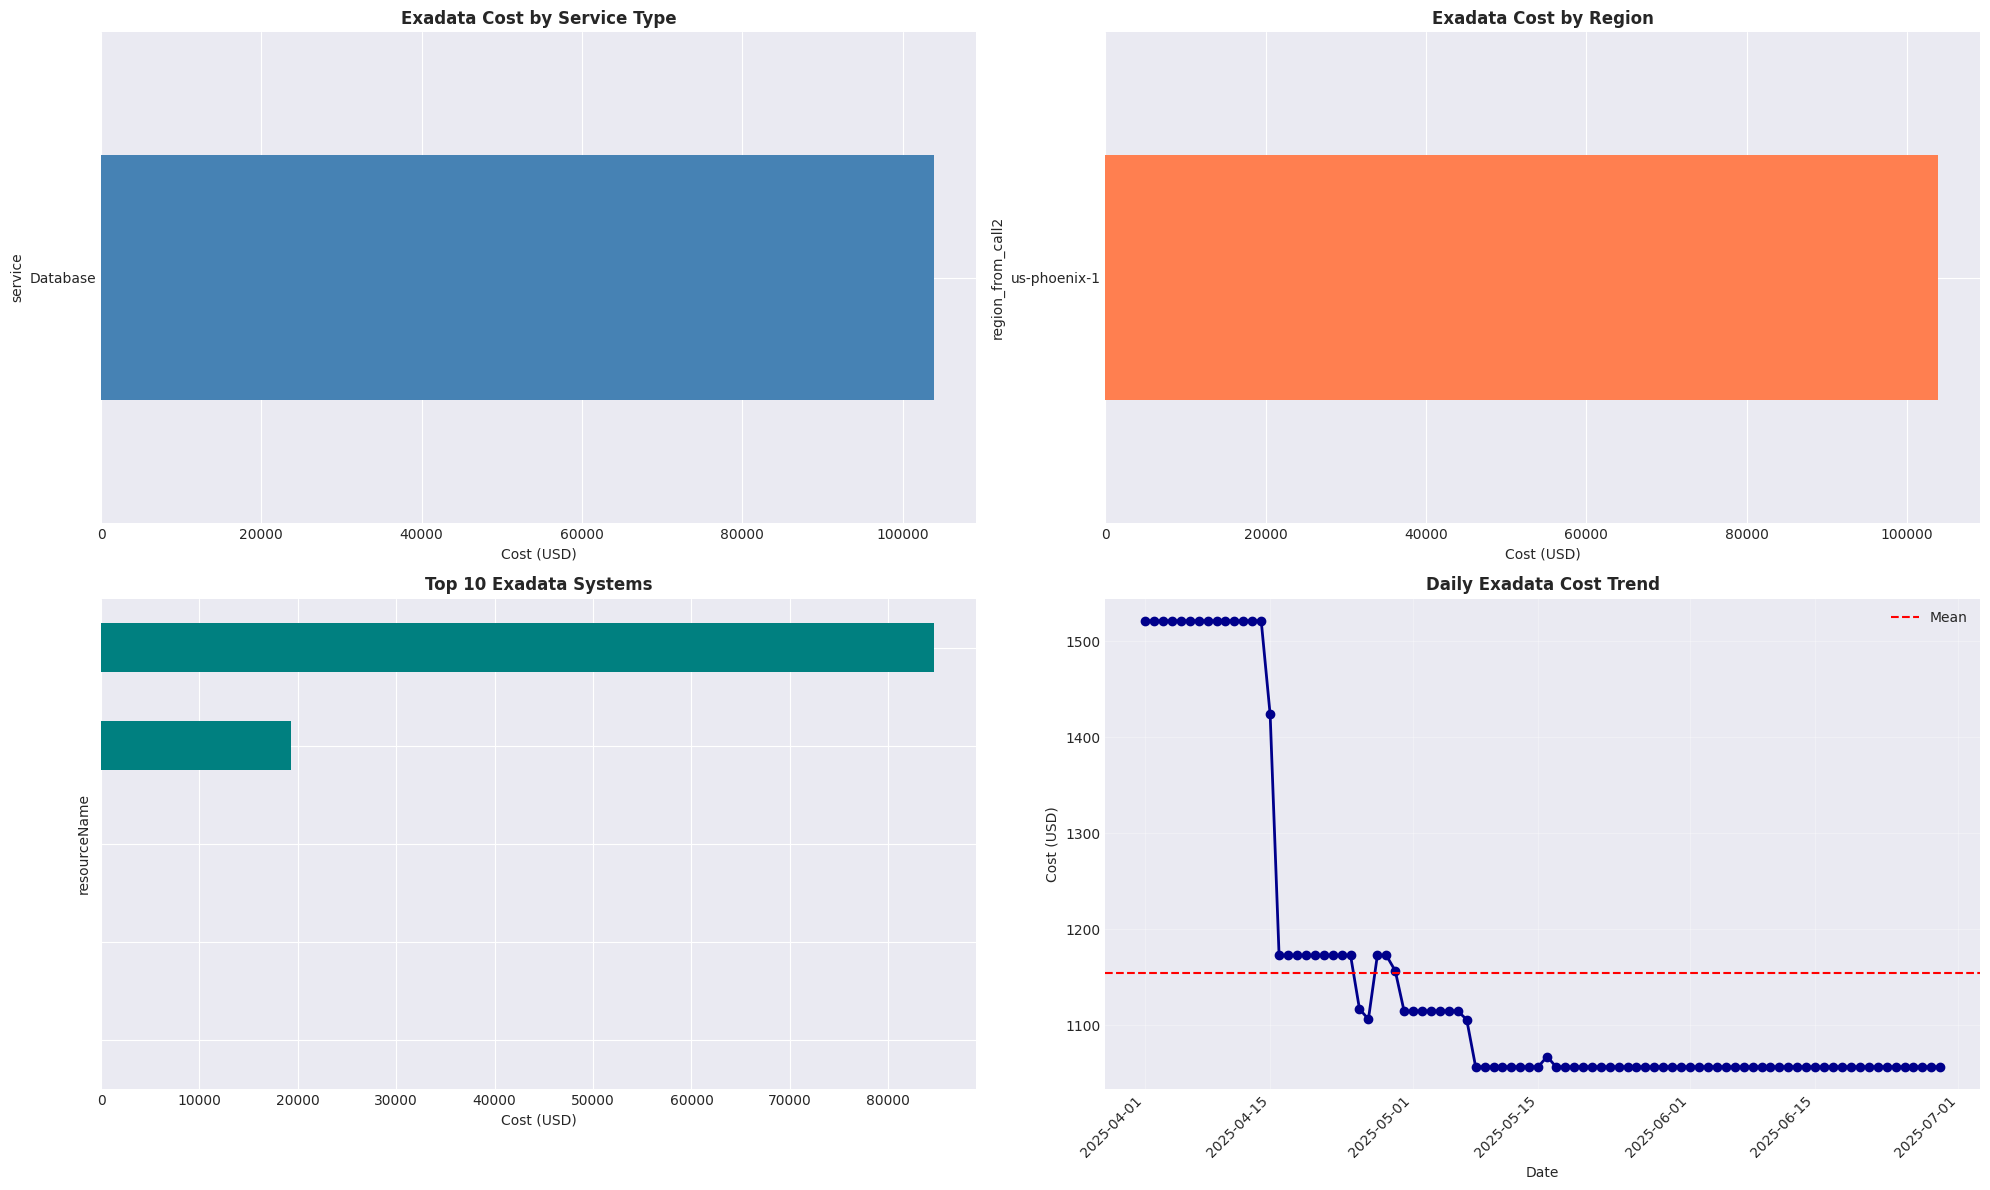


✅ Exadata Analysis Complete


In [106]:
if len(exadata_df) > 0:
    print("\n" + "="*160)
    print(" "*50 + "🏢 EXADATA INFRASTRUCTURE ANALYSIS")
    print("="*160)
    
    # Prepare SKU information
    exadata_df_work = exadata_df.copy()
    exadata_df_work['sku_clean'] = exadata_df_work['skuName'].fillna(exadata_df_work.get('skuPartNumber', '')).fillna('Unknown SKU')
    
    # ========================================================================================
    # EXECUTIVE SUMMARY
    # ========================================================================================
    total_exadata_cost = exadata_df_work['computedAmount'].sum()
    total_exadata_hours = exadata_df_work['computedQuantity'].sum()
    unique_systems = exadata_df_work['resourceId'].nunique()
    avg_hourly_rate = total_exadata_cost / total_exadata_hours if total_exadata_hours > 0 else 0
    
    print("\n📊 EXECUTIVE SUMMARY:")
    print("-" * 160)
    print(f"{'Total Exadata Spend:':<40} ${total_exadata_cost:>22,.2f}")
    print(f"{'Percentage of Total Cloud Spend:':<40} {(total_exadata_cost/df['computedAmount'].sum())*100:>21.2f}%")
    print(f"{'Total Compute Hours:':<40} {total_exadata_hours:>22,.2f}")
    print(f"{'Average Hourly Rate:':<40} ${avg_hourly_rate:>22,.2f}")
    print(f"{'Unique Exadata Systems:':<40} {unique_systems:>22,}")
    print(f"{'Unique Compartments:':<40} {exadata_df_work['compartment_name_clean'].nunique():>22,}")
    print(f"{'Regions with Exadata:':<40} {exadata_df_work['region_from_call2'].nunique():>22,}")
    print(f"{'Date Range:':<40} {str(exadata_df_work['timeUsageStarted'].min())[:10]} to {str(exadata_df_work['timeUsageEnded'].max())[:10]:>6}")
    print(f"{'Projected Monthly Cost (current rate):':<40} ${avg_hourly_rate * 24 * 30:>22,.2f}")
    print(f"{'Projected Annual Cost (current rate):':<40} ${avg_hourly_rate * 24 * 365:>22,.2f}")
    
    # ========================================================================================
    # SERVICE TYPE BREAKDOWN
    # ========================================================================================
    print("\n\n💼 EXADATA SERVICE TYPE BREAKDOWN:")
    print("-" * 160)
    service_breakdown = exadata_df_work.groupby('service').agg({
        'computedAmount': 'sum',
        'computedQuantity': 'sum',
        'resourceId': 'nunique'
    }).sort_values('computedAmount', ascending=False)
    
    print(f"{'Service Type':<50} {'Total Cost':>18} {'% of Total':>12} {'Hours':>18} {'Systems':>10}")
    print("-" * 160)
    for service, row in service_breakdown.iterrows():
        pct = (row['computedAmount'] / total_exadata_cost) * 100
        print(f"{service:<50} ${row['computedAmount']:>17,.2f} {pct:>11.1f}% {row['computedQuantity']:>18,.1f} {row['resourceId']:>10}")
    
    # ========================================================================================
    # SKU/CONFIGURATION ANALYSIS
    # ========================================================================================
    print("\n\n🔧 SKU/CONFIGURATION ANALYSIS (Top 15):")
    print("-" * 160)
    sku_analysis = exadata_df_work.groupby('sku_clean').agg({
        'computedAmount': 'sum',
        'computedQuantity': 'sum',
        'resourceId': 'nunique'
    }).sort_values('computedAmount', ascending=False).head(15)
    
    sku_analysis['cost_per_hour'] = sku_analysis['computedAmount'] / sku_analysis['computedQuantity'].replace(0, 1)
    sku_analysis['cost_per_system'] = sku_analysis['computedAmount'] / sku_analysis['resourceId']
    
    print(f"{'SKU/Configuration':<80} {'Total Cost':>18} {'$/Hour':>12} {'$/System':>15}")
    print("-" * 160)
    for sku, row in sku_analysis.iterrows():
        sku_display = str(sku)[:78]
        print(f"{sku_display:<80} ${row['computedAmount']:>17,.2f} ${row['cost_per_hour']:>11,.2f} ${row['cost_per_system']:>14,.2f}")
    
    # ========================================================================================
    # REGIONAL DISTRIBUTION
    # ========================================================================================
    print("\n\n🌍 REGIONAL DISTRIBUTION:")
    print("-" * 160)
    region_breakdown = exadata_df_work.groupby('region_from_call2').agg({
        'computedAmount': 'sum',
        'resourceId': 'nunique'
    }).sort_values('computedAmount', ascending=False)
    
    print(f"{'Region':<40} {'Total Cost':>18} {'% of Total':>12} {'Systems':>12}")
    print("-" * 160)
    for region, row in region_breakdown.iterrows():
        pct = (row['computedAmount'] / total_exadata_cost) * 100
        print(f"{region:<40} ${row['computedAmount']:>17,.2f} {pct:>11.1f}% {row['resourceId']:>12}")
    
    # ========================================================================================
    # COMPARTMENT DISTRIBUTION (Top 20)
    # ========================================================================================
    print("\n\n📦 COMPARTMENT DISTRIBUTION (Top 20):")
    print("-" * 160)
    compartment_breakdown = exadata_df_work.groupby(['compartment_name_clean', 'compartmentPath']).agg({
        'computedAmount': 'sum',
        'resourceId': 'nunique'
    }).sort_values('computedAmount', ascending=False).head(20)
    
    print(f"{'Rank':<6} {'Compartment':<45} {'Total Cost':>18} {'% Total':>10} {'Systems':>10}")
    print(f"{'':6} {'Full Path':<150}")
    print("-" * 160)
    for idx, ((comp_name, comp_path), row) in enumerate(compartment_breakdown.iterrows(), 1):
        pct = (row['computedAmount'] / total_exadata_cost) * 100
        print(f"{idx:<6} {comp_name[:43]:<45} ${row['computedAmount']:>17,.2f} {pct:>9.1f}% {row['resourceId']:>10}")
        print(f"{'':6} {comp_path[:148]}")
        print()
    
    # ========================================================================================
    # TOP 25 INDIVIDUAL EXADATA SYSTEMS
    # ========================================================================================
    print("\n\n🖥️  TOP 25 INDIVIDUAL EXADATA SYSTEMS BY COST:")
    print("-" * 160)
    system_details = exadata_df_work.groupby(['resourceId', 'resourceName', 'service', 'region_from_call2']).agg({
        'computedAmount': 'sum',
        'computedQuantity': 'sum'
    }).reset_index().sort_values('computedAmount', ascending=False).head(25)
    
    system_details['hourly_rate'] = system_details['computedAmount'] / system_details['computedQuantity'].replace(0, 1)
    
    print(f"{'Rank':<6} {'Resource Name':<45} {'Service':<30} {'Total Cost':>18}")
    print(f"{'':6} {'Region':<30} {'Monthly Projection':>18} {'Daily Cost':>18}")
    print("-" * 160)
    for idx, row in system_details.iterrows():
        rank = system_details.index.get_loc(idx) + 1
        print(f"{rank:<6} {str(row['resourceName'])[:43]:<45} {str(row['service'])[:28]:<30} ${row['computedAmount']:>17,.2f}")
        print(f"{'':6} {str(row['region_from_call2']):<30} ${row['computedAmount']/30*30:>17,.2f} ${row['computedAmount']/30:>17,.2f}")
        print()
    
    # ========================================================================================
    # DAILY COST TREND
    # ========================================================================================
    print("\n\n📈 DAILY COST TREND:")
    print("-" * 160)
    daily_exadata = exadata_df_work.groupby('date').agg({
        'computedAmount': 'sum'
    }).reset_index()
    daily_exadata['date'] = pd.to_datetime(daily_exadata['date'])
    
    print(f"Average Daily Cost: ${daily_exadata['computedAmount'].mean():,.2f}")
    print(f"Median Daily Cost:  ${daily_exadata['computedAmount'].median():,.2f}")
    print(f"Min Daily Cost:     ${daily_exadata['computedAmount'].min():,.2f}")
    print(f"Max Daily Cost:     ${daily_exadata['computedAmount'].max():,.2f}")
    print(f"Std Deviation:      ${daily_exadata['computedAmount'].std():,.2f}")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # 1. Service distribution
    ax = axes[0, 0]
    service_breakdown['computedAmount'].head(8).plot(kind='barh', ax=ax, color='steelblue')
    ax.set_xlabel('Cost (USD)')
    ax.set_title('Exadata Cost by Service Type', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    
    # 2. Regional distribution
    ax = axes[0, 1]
    region_breakdown['computedAmount'].plot(kind='barh', ax=ax, color='coral')
    ax.set_xlabel('Cost (USD)')
    ax.set_title('Exadata Cost by Region', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    
    # 3. Top 10 systems
    ax = axes[1, 0]
    top_systems = system_details.head(10).sort_values('computedAmount')
    top_systems.set_index(top_systems['resourceName'].str[:30])['computedAmount'].plot(kind='barh', ax=ax, color='teal')
    ax.set_xlabel('Cost (USD)')
    ax.set_title('Top 10 Exadata Systems', fontsize=12, fontweight='bold')
    
    # 4. Daily trend
    ax = axes[1, 1]
    ax.plot(daily_exadata['date'], daily_exadata['computedAmount'], marker='o', linewidth=2, color='darkblue')
    ax.axhline(y=daily_exadata['computedAmount'].mean(), color='red', linestyle='--', label='Mean')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cost (USD)')
    ax.set_title('Daily Exadata Cost Trend', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Exadata Analysis Complete")
else:
    print("\n⚠️ No Exadata infrastructure found in the dataset")

## Section 3: Database Infrastructure - Comprehensive Cost Analysis


                                                  🗄️  DATABASE INFRASTRUCTURE ANALYSIS

📊 EXECUTIVE SUMMARY:
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Total Database Spend:                    $            103,933.94
Percentage of Total Cloud Spend:                         96.94%
Total Compute Hours:                                  22,414.22
Average Hourly Rate:                     $                  4.64
Unique Database Instances:                                    5
Database Service Types:                                       1
Unique Compartments:                                          1
Regions with Databases:                                       1
Date Range:                              2025-04-01 to 2025-06-30
Projected Monthly Cost (current rate):   $              3,338.61
Projected Annual Cost (current rate):    $             40,619.81


📋 DATABASE SERVIC

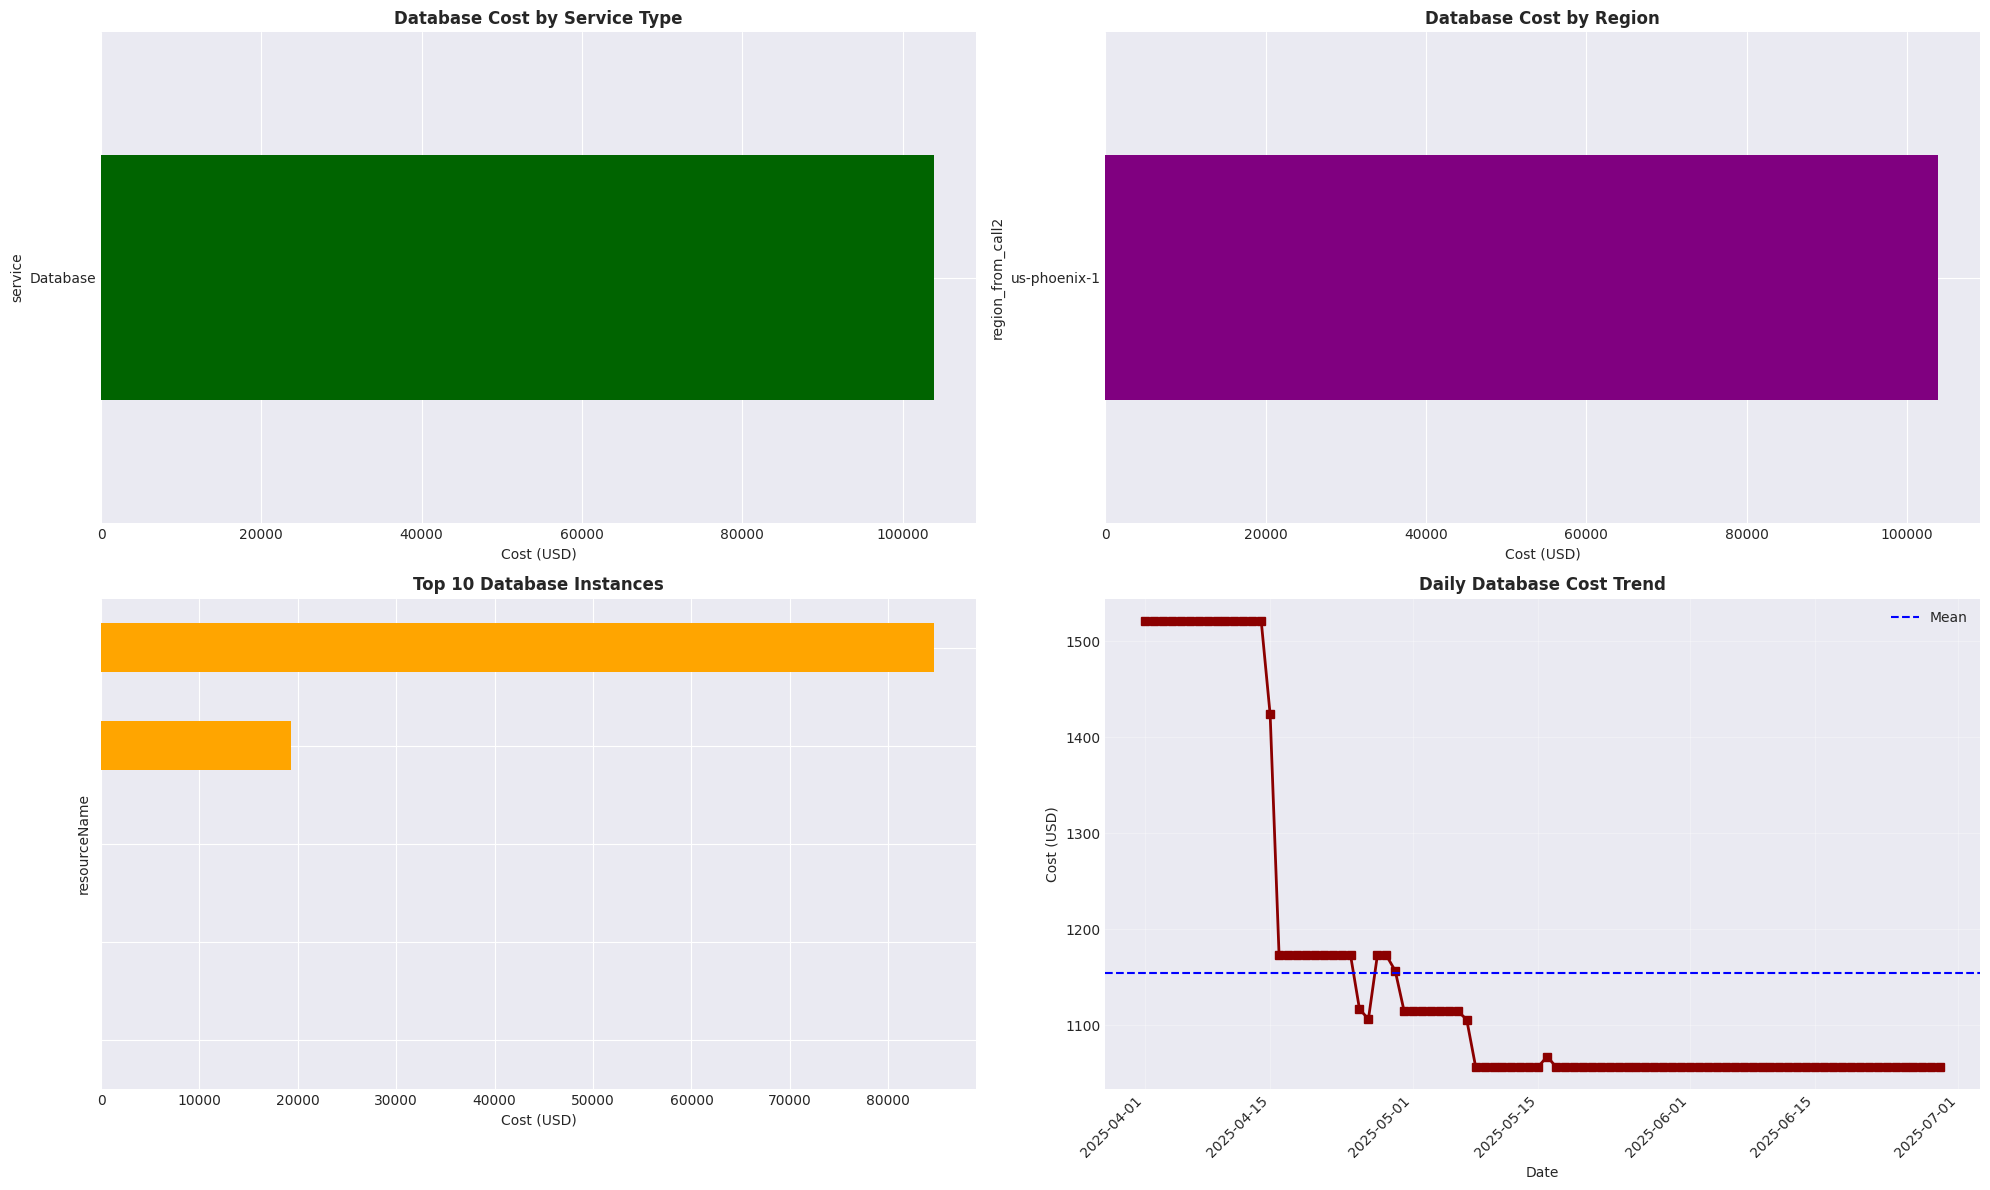


✅ Database Analysis Complete


In [107]:
if len(database_df) > 0:
    print("\n" + "="*160)
    print(" "*50 + "🗄️  DATABASE INFRASTRUCTURE ANALYSIS")
    print("="*160)
    
    # Prepare SKU information
    database_df_work = database_df.copy()
    database_df_work['sku_clean'] = database_df_work['skuName'].fillna(database_df_work.get('skuPartNumber', '')).fillna('Unknown SKU')
    
    # ========================================================================================
    # EXECUTIVE SUMMARY
    # ========================================================================================
    total_db_cost = database_df_work['computedAmount'].sum()
    total_db_hours = database_df_work['computedQuantity'].sum()
    unique_databases = database_df_work['resourceId'].nunique()
    avg_db_hourly_rate = total_db_cost / total_db_hours if total_db_hours > 0 else 0
    
    print("\n📊 EXECUTIVE SUMMARY:")
    print("-" * 160)
    print(f"{'Total Database Spend:':<40} ${total_db_cost:>22,.2f}")
    print(f"{'Percentage of Total Cloud Spend:':<40} {(total_db_cost/df['computedAmount'].sum())*100:>21.2f}%")
    print(f"{'Total Compute Hours:':<40} {total_db_hours:>22,.2f}")
    print(f"{'Average Hourly Rate:':<40} ${avg_db_hourly_rate:>22,.2f}")
    print(f"{'Unique Database Instances:':<40} {unique_databases:>22,}")
    print(f"{'Database Service Types:':<40} {database_df_work['service'].nunique():>22,}")
    print(f"{'Unique Compartments:':<40} {database_df_work['compartment_name_clean'].nunique():>22,}")
    print(f"{'Regions with Databases:':<40} {database_df_work['region_from_call2'].nunique():>22,}")
    print(f"{'Date Range:':<40} {str(database_df_work['timeUsageStarted'].min())[:10]} to {str(database_df_work['timeUsageEnded'].max())[:10]:>6}")
    print(f"{'Projected Monthly Cost (current rate):':<40} ${avg_db_hourly_rate * 24 * 30:>22,.2f}")
    print(f"{'Projected Annual Cost (current rate):':<40} ${avg_db_hourly_rate * 24 * 365:>22,.2f}")
    
    # ========================================================================================
    # DATABASE SERVICE TYPE BREAKDOWN
    # ========================================================================================
    print("\n\n📋 DATABASE SERVICE TYPE BREAKDOWN:")
    print("-" * 160)
    db_service_breakdown = database_df_work.groupby('service').agg({
        'computedAmount': 'sum',
        'computedQuantity': 'sum',
        'resourceId': 'nunique'
    }).sort_values('computedAmount', ascending=False)
    
    print(f"{'Database Service':<50} {'Total Cost':>18} {'% of Total':>12} {'Hours':>18} {'Instances':>10}")
    print("-" * 160)
    for service, row in db_service_breakdown.iterrows():
        pct = (row['computedAmount'] / total_db_cost) * 100
        print(f"{service:<50} ${row['computedAmount']:>17,.2f} {pct:>11.1f}% {row['computedQuantity']:>18,.1f} {row['resourceId']:>10}")
    
    # ========================================================================================
    # DATABASE SKU/SHAPE ANALYSIS
    # ========================================================================================
    print("\n\n🔧 DATABASE SKU/SHAPE ANALYSIS (Top 20):")
    print("-" * 160)
    db_sku_analysis = database_df_work.groupby('sku_clean').agg({
        'computedAmount': 'sum',
        'computedQuantity': 'sum',
        'resourceId': 'nunique'
    }).sort_values('computedAmount', ascending=False).head(20)
    
    db_sku_analysis['cost_per_hour'] = db_sku_analysis['computedAmount'] / db_sku_analysis['computedQuantity'].replace(0, 1)
    db_sku_analysis['cost_per_instance'] = db_sku_analysis['computedAmount'] / db_sku_analysis['resourceId']
    
    print(f"{'Database SKU/Shape':<80} {'Total Cost':>18} {'$/Hour':>12} {'$/Instance':>15}")
    print("-" * 160)
    for sku, row in db_sku_analysis.iterrows():
        sku_display = str(sku)[:78]
        print(f"{sku_display:<80} ${row['computedAmount']:>17,.2f} ${row['cost_per_hour']:>11,.2f} ${row['cost_per_instance']:>14,.2f}")
    
    # ========================================================================================
    # DATABASE REGIONAL DISTRIBUTION
    # ========================================================================================
    print("\n\n🌍 DATABASE REGIONAL DISTRIBUTION:")
    print("-" * 160)
    db_region_breakdown = database_df_work.groupby('region_from_call2').agg({
        'computedAmount': 'sum',
        'resourceId': 'nunique'
    }).sort_values('computedAmount', ascending=False)
    
    print(f"{'Region':<40} {'Total Cost':>18} {'% of Total':>12} {'Instances':>12}")
    print("-" * 160)
    for region, row in db_region_breakdown.iterrows():
        pct = (row['computedAmount'] / total_db_cost) * 100
        print(f"{region:<40} ${row['computedAmount']:>17,.2f} {pct:>11.1f}% {row['resourceId']:>12}")
    
    # ========================================================================================
    # DATABASE COMPARTMENT DISTRIBUTION (Top 20)
    # ========================================================================================
    print("\n\n📦 DATABASE COMPARTMENT DISTRIBUTION (Top 20):")
    print("-" * 160)
    db_compartment_breakdown = database_df_work.groupby(['compartment_name_clean', 'compartmentPath']).agg({
        'computedAmount': 'sum',
        'resourceId': 'nunique'
    }).sort_values('computedAmount', ascending=False).head(20)
    
    print(f"{'Rank':<6} {'Compartment':<45} {'Total Cost':>18} {'% Total':>10} {'Instances':>12}")
    print(f"{'':6} {'Full Path':<150}")
    print("-" * 160)
    for idx, ((comp_name, comp_path), row) in enumerate(db_compartment_breakdown.iterrows(), 1):
        pct = (row['computedAmount'] / total_db_cost) * 100
        print(f"{idx:<6} {comp_name[:43]:<45} ${row['computedAmount']:>17,.2f} {pct:>9.1f}% {row['resourceId']:>12}")
        print(f"{'':6} {comp_path[:148]}")
        print()
    
    # ========================================================================================
    # TOP 30 INDIVIDUAL DATABASE INSTANCES
    # ========================================================================================
    print("\n\n📊 TOP 30 INDIVIDUAL DATABASE INSTANCES BY COST:")
    print("-" * 160)
    db_instances = database_df_work.groupby(['resourceId', 'resourceName', 'service', 'region_from_call2', 'compartment_name_clean']).agg({
        'computedAmount': 'sum',
        'computedQuantity': 'sum'
    }).reset_index().sort_values('computedAmount', ascending=False).head(30)
    
    db_instances['hourly_rate'] = db_instances['computedAmount'] / db_instances['computedQuantity'].replace(0, 1)
    
    print(f"{'Rank':<6} {'Database Instance':<45} {'Service':<25} {'Total Cost':>18}")
    print(f"{'':6} {'Region':<25} {'Compartment':<40} {'Daily Cost':>18}")
    print("-" * 160)
    for idx, row in db_instances.iterrows():
        rank = db_instances.index.get_loc(idx) + 1
        print(f"{rank:<6} {str(row['resourceName'])[:43]:<45} {str(row['service'])[:23]:<25} ${row['computedAmount']:>17,.2f}")
        print(f"{'':6} {str(row['region_from_call2']):<25} {str(row['compartment_name_clean'])[:38]:<40} ${row['computedAmount']/30:>17,.2f}")
        print()
    
    # ========================================================================================
    # DAILY COST TREND
    # ========================================================================================
    print("\n\n📈 DAILY DATABASE COST TREND:")
    print("-" * 160)
    daily_db = database_df_work.groupby('date').agg({
        'computedAmount': 'sum'
    }).reset_index()
    daily_db['date'] = pd.to_datetime(daily_db['date'])
    
    print(f"Average Daily Cost: ${daily_db['computedAmount'].mean():,.2f}")
    print(f"Median Daily Cost:  ${daily_db['computedAmount'].median():,.2f}")
    print(f"Min Daily Cost:     ${daily_db['computedAmount'].min():,.2f}")
    print(f"Max Daily Cost:     ${daily_db['computedAmount'].max():,.2f}")
    print(f"Std Deviation:      ${daily_db['computedAmount'].std():,.2f}")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # 1. Service distribution
    ax = axes[0, 0]
    db_service_breakdown['computedAmount'].head(10).plot(kind='barh', ax=ax, color='darkgreen')
    ax.set_xlabel('Cost (USD)')
    ax.set_title('Database Cost by Service Type', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    
    # 2. Regional distribution
    ax = axes[0, 1]
    db_region_breakdown['computedAmount'].plot(kind='barh', ax=ax, color='purple')
    ax.set_xlabel('Cost (USD)')
    ax.set_title('Database Cost by Region', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    
    # 3. Top 10 instances
    ax = axes[1, 0]
    top_db_instances = db_instances.head(10).sort_values('computedAmount')
    top_db_instances.set_index(top_db_instances['resourceName'].str[:30])['computedAmount'].plot(kind='barh', ax=ax, color='orange')
    ax.set_xlabel('Cost (USD)')
    ax.set_title('Top 10 Database Instances', fontsize=12, fontweight='bold')
    
    # 4. Daily trend
    ax = axes[1, 1]
    ax.plot(daily_db['date'], daily_db['computedAmount'], marker='s', linewidth=2, color='darkred')
    ax.axhline(y=daily_db['computedAmount'].mean(), color='blue', linestyle='--', label='Mean')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cost (USD)')
    ax.set_title('Daily Database Cost Trend', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Database Analysis Complete")
else:
    print("\n⚠️ No Database infrastructure found in the dataset")

## Section 4: Combined Exadata + Database Analysis & Comparisons


                                             📊 COMBINED EXADATA & DATABASE ANALYSIS

📊 COMBINED SUMMARY:
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Total Exadata + Database Spend:          $            103,933.94
% of Total Cloud Spend:                                  96.94%

Exadata Component:                       $            103,933.94 (100.0%)
Database Component:                      $            103,933.94 (100.0%)
Other Cloud Services:                    $              3,278.34 (  3.1%)


🔄 COST BREAKDOWN BY CATEGORY:
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Category                                                                             Cost      % of Combined
-------------------------------------------------------------------------------

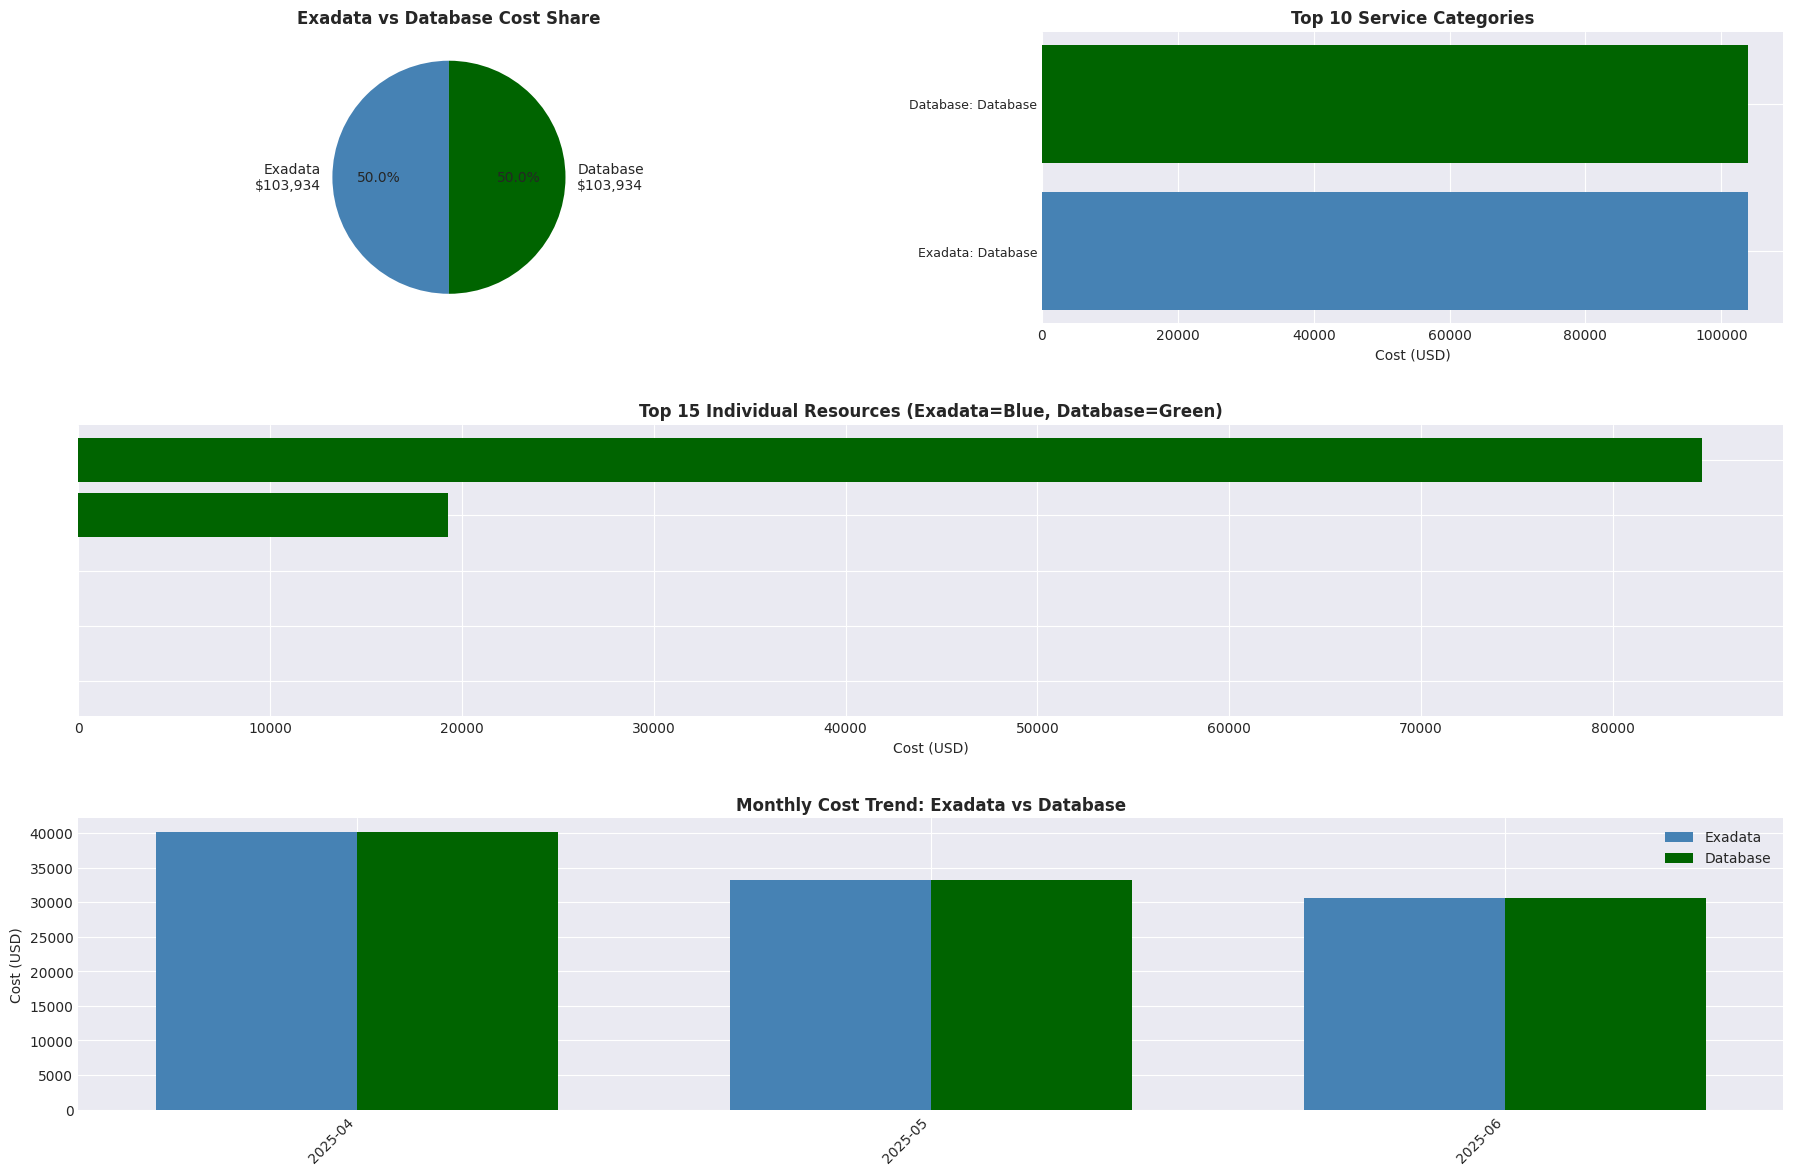


✅ Combined Analysis Complete


In [108]:
if len(combined_df) > 0:
    print("\n" + "="*160)
    print(" "*45 + "📊 COMBINED EXADATA & DATABASE ANALYSIS")
    print("="*160)
    
    # ========================================================================================
    # COMBINED EXECUTIVE SUMMARY
    # ========================================================================================
    combined_cost = combined_df['computedAmount'].sum()
    combined_pct_total = (combined_cost / df['computedAmount'].sum()) * 100
    
    exadata_cost = exadata_df['computedAmount'].sum() if len(exadata_df) > 0 else 0
    exadata_pct = (exadata_cost / combined_cost * 100) if combined_cost > 0 else 0
    
    database_cost = database_df['computedAmount'].sum() if len(database_df) > 0 else 0
    database_pct = (database_cost / combined_cost * 100) if combined_cost > 0 else 0
    
    print("\n📊 COMBINED SUMMARY:")
    print("-" * 160)
    print(f"{'Total Exadata + Database Spend:':<40} ${combined_cost:>22,.2f}")
    print(f"{'% of Total Cloud Spend:':<40} {combined_pct_total:>21.2f}%")
    print(f"\n{'Exadata Component:':<40} ${exadata_cost:>22,.2f} ({exadata_pct:>5.1f}%)")
    print(f"{'Database Component:':<40} ${database_cost:>22,.2f} ({database_pct:>5.1f}%)")
    print(f"{'Other Cloud Services:':<40} ${df['computedAmount'].sum() - combined_cost:>22,.2f} ({100 - combined_pct_total:>5.1f}%)")
    
    # ========================================================================================
    # COST BREAKDOWN COMPARISON
    # ========================================================================================
    print("\n\n🔄 COST BREAKDOWN BY CATEGORY:")
    print("-" * 160)
    
    category_data = []
    if len(exadata_df) > 0:
        for service in exadata_df['service'].unique():
            cost = exadata_df[exadata_df['service'] == service]['computedAmount'].sum()
            category_data.append({'Category': f'Exadata: {service}', 'Cost': cost, 'Type': 'Exadata'})
    
    if len(database_df) > 0:
        for service in database_df['service'].unique():
            cost = database_df[database_df['service'] == service]['computedAmount'].sum()
            category_data.append({'Category': f'Database: {service}', 'Cost': cost, 'Type': 'Database'})
    
    if category_data:
        category_df = pd.DataFrame(category_data).sort_values('Cost', ascending=False)
        print(f"{'Category':<70} {'Cost':>18} {'% of Combined':>18}")
        print("-" * 160)
        for _, row in category_df.iterrows():
            pct = (row['Cost'] / combined_cost) * 100
            print(f"{row['Category']:<70} ${row['Cost']:>17,.2f} {pct:>17.1f}%")
    
    # ========================================================================================
    # TOP RESOURCES ACROSS BOTH (Top 30)
    # ========================================================================================
    print("\n\n🏆 TOP 30 COMBINED EXADATA & DATABASE RESOURCES:")
    print("-" * 160)
    
    all_resources = combined_df.groupby(['resourceId', 'resourceName', 'service', 'region_from_call2']).agg({
        'computedAmount': 'sum',
        'computedQuantity': 'sum'
    }).reset_index().sort_values('computedAmount', ascending=False).head(30)
    
    print(f"{'Rank':<6} {'Resource Name':<45} {'Type':<18} {'Service':<25} {'Cost':>18}")
    print(f"{'':6} {'Region':<30} {'Daily Cost':>18}")
    print("-" * 160)
    
    for idx, row in all_resources.iterrows():
        rank = all_resources.index.get_loc(idx) + 1
        resource_type = 'Exadata' if 'Exadata' in str(row['service']) else 'Database'
        print(f"{rank:<6} {str(row['resourceName'])[:43]:<45} {resource_type:<18} {str(row['service'])[:23]:<25} ${row['computedAmount']:>17,.2f}")
        print(f"{'':6} {str(row['region_from_call2']):<30} ${row['computedAmount']/30:>17,.2f}")
        print()
    
    # ========================================================================================
    # MONTHLY TREND COMPARISON
    # ========================================================================================
    print("\n\n📈 MONTHLY COST TREND COMPARISON:")
    print("-" * 160)
    
    combined_df['month'] = pd.to_datetime(combined_df['timeUsageStarted']).dt.to_period('M')
    monthly_combined = combined_df.groupby('month').agg({
        'computedAmount': 'sum'
    }).reset_index()
    monthly_combined['month'] = monthly_combined['month'].astype(str)
    
    if len(exadata_df) > 0:
        exadata_df['month'] = pd.to_datetime(exadata_df['timeUsageStarted']).dt.to_period('M')
        monthly_exadata = exadata_df.groupby('month').agg({
            'computedAmount': 'sum'
        }).reset_index()
        monthly_exadata['month'] = monthly_exadata['month'].astype(str)
        monthly_exadata.set_index('month', inplace=True)
        monthly_exadata.rename(columns={'computedAmount': 'exadata_cost'}, inplace=True)
    else:
        monthly_exadata = pd.DataFrame()
    
    if len(database_df) > 0:
        database_df['month'] = pd.to_datetime(database_df['timeUsageStarted']).dt.to_period('M')
        monthly_database = database_df.groupby('month').agg({
            'computedAmount': 'sum'
        }).reset_index()
        monthly_database['month'] = monthly_database['month'].astype(str)
        monthly_database.set_index('month', inplace=True)
        monthly_database.rename(columns={'computedAmount': 'database_cost'}, inplace=True)
    else:
        monthly_database = pd.DataFrame()
    
    monthly_combined.set_index('month', inplace=True)
    monthly_combined.rename(columns={'computedAmount': 'total_cost'}, inplace=True)
    
    # Merge and display
    if len(monthly_exadata) > 0 and len(monthly_database) > 0:
        monthly_merge = monthly_combined.join([monthly_exadata, monthly_database], how='outer').fillna(0)
        print(f"{'Month':<12} {'Total Combined':>18} {'Exadata':>18} {'Database':>18} {'Exadata %':>12} {'DB %':>12}")
        print("-" * 160)
        for month, row in monthly_merge.iterrows():
            ex_pct = (row['exadata_cost'] / row['total_cost'] * 100) if row['total_cost'] > 0 else 0
            db_pct = (row['database_cost'] / row['total_cost'] * 100) if row['total_cost'] > 0 else 0
            print(f"{month:<12} ${row['total_cost']:>17,.2f} ${row['exadata_cost']:>17,.2f} ${row['database_cost']:>17,.2f} {ex_pct:>11.1f}% {db_pct:>11.1f}%")
    
    # ========================================================================================
    # VISUALIZATIONS
    # ========================================================================================
    fig = plt.figure(figsize=(22, 14))
    gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)
    
    # 1. Pie chart - Exadata vs Database
    ax = fig.add_subplot(gs[0, 0])
    sizes = [exadata_cost, database_cost]
    labels = [f'Exadata\n${exadata_cost:,.0f}', f'Database\n${database_cost:,.0f}']
    colors = ['steelblue', 'darkgreen']
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.set_title('Exadata vs Database Cost Share', fontsize=12, fontweight='bold')
    
    # 2. Cost categories
    ax = fig.add_subplot(gs[0, 1])
    if category_data:
        category_df_plot = pd.DataFrame(category_data).sort_values('Cost', ascending=True).tail(10)
        colors_cat = ['steelblue' if x == 'Exadata' else 'darkgreen' for x in category_df_plot['Type']]
        ax.barh(range(len(category_df_plot)), category_df_plot['Cost'], color=colors_cat)
        ax.set_yticks(range(len(category_df_plot)))
        ax.set_yticklabels([x[:40] for x in category_df_plot['Category']], fontsize=9)
        ax.set_xlabel('Cost (USD)')
        ax.set_title('Top 10 Service Categories', fontsize=12, fontweight='bold')
    
    # 3. Top 15 resources
    ax = fig.add_subplot(gs[1, :])
    top_15 = all_resources.head(15).sort_values('computedAmount')
    colors_res = ['steelblue' if 'Exadata' in x else 'darkgreen' for x in top_15['service']]
    ax.barh(range(len(top_15)), top_15['computedAmount'], color=colors_res)
    ax.set_yticks(range(len(top_15)))
    ax.set_yticklabels([x[:45] for x in top_15['resourceName']], fontsize=9)
    ax.set_xlabel('Cost (USD)')
    ax.set_title('Top 15 Individual Resources (Exadata=Blue, Database=Green)', fontsize=12, fontweight='bold')
    
    # 4. Monthly trend
    ax = fig.add_subplot(gs[2, :])
    if len(monthly_exadata) > 0 and len(monthly_database) > 0:
        monthly_merge_plot = monthly_merge.reset_index()
        x_pos = range(len(monthly_merge_plot))
        width = 0.35
        ax.bar([p - width/2 for p in x_pos], monthly_merge_plot['exadata_cost'], width, label='Exadata', color='steelblue')
        ax.bar([p + width/2 for p in x_pos], monthly_merge_plot['database_cost'], width, label='Database', color='darkgreen')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(monthly_merge_plot['month'], rotation=45, ha='right')
        ax.set_ylabel('Cost (USD)')
        ax.set_title('Monthly Cost Trend: Exadata vs Database', fontsize=12, fontweight='bold')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Combined Analysis Complete")
else:
    print("\n⚠️ No Exadata or Database infrastructure found")

## Section 5: Export Analysis Reports

In [109]:
import os
from datetime import datetime

# Create output directory if not exists
output_dir = '../output/analysis_reports'
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print("="*160)
print("EXADATA & DATABASE ANALYSIS - EXPORT REPORTS")
print("="*160)
print()

# ============================================================================
# 1. EXADATA DETAILED REPORT - CSV
# ============================================================================
print("1. Exporting Exadata Detailed Resource Report...")
try:
    exadata_export = exadata_df.copy()
    
    # Select and reorder key columns
    export_cols = ['date', 'service', 'resourceName', 'compartmentPath', 'region_from_call2', 'skuName', 
                   'computedQuantity', 'unitOfMeasure', 'computedAmount', 'lineStatus', 'timeUsageStarted']
    available_cols = [col for col in export_cols if col in exadata_export.columns]
    exadata_export = exadata_export[available_cols].sort_values('computedAmount', ascending=False)
    
    filename = f'{output_dir}/exadata_resources_{timestamp}.csv'
    exadata_export.to_csv(filename, index=False)
    print(f"   ✓ Saved: {filename} ({len(exadata_export)} rows)")
except Exception as e:
    print(f"   ✗ Error: {str(e)}")

print()

# ============================================================================
# 2. DATABASE DETAILED REPORT - CSV
# ============================================================================
print("2. Exporting Database Detailed Resource Report...")
try:
    database_export = database_df.copy()
    
    export_cols = ['date', 'service', 'resourceName', 'compartmentPath', 'region_from_call2', 'skuName', 
                   'computedQuantity', 'unitOfMeasure', 'computedAmount', 'lineStatus', 'timeUsageStarted']
    available_cols = [col for col in export_cols if col in database_export.columns]
    database_export = database_export[available_cols].sort_values('computedAmount', ascending=False)
    
    filename = f'{output_dir}/database_resources_{timestamp}.csv'
    database_export.to_csv(filename, index=False)
    print(f"   ✓ Saved: {filename} ({len(database_export)} rows)")
except Exception as e:
    print(f"   ✗ Error: {str(e)}")

print()

# ============================================================================
# 3. EXADATA EXECUTIVE SUMMARY - TEXT
# ============================================================================
print("3. Exporting Exadata Executive Summary Report...")
try:
    with open(f'{output_dir}/exadata_summary_{timestamp}.txt', 'w') as f:
        f.write("="*160 + "\n")
        f.write("EXADATA INFRASTRUCTURE - EXECUTIVE SUMMARY\n")
        f.write("="*160 + "\n\n")
        
        f.write(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("COST METRICS:\n")
        f.write("-" * 160 + "\n")
        total_cost_exadata = exadata_df['computedAmount'].sum()
        total_cost_all = df['computedAmount'].sum()
        pct_of_total = (total_cost_exadata / total_cost_all * 100) if total_cost_all > 0 else 0
        
        f.write(f"  Total Exadata Cost:        ${total_cost_exadata:>15,.2f}\n")
        f.write(f"  Percentage of Total:       {pct_of_total:>15.2f}%\n")
        f.write(f"  Date Range:                {exadata_df['date'].min()} to {exadata_df['date'].max()}\n")
        f.write(f"  Total Usage Hours:         {exadata_df['computedQuantity'].sum():>15,.0f}\n")
        f.write(f"  Avg Hourly Cost:           ${(total_cost_exadata / exadata_df['computedQuantity'].sum() if exadata_df['computedQuantity'].sum() > 0 else 0):>15,.2f}\n\n")
        
        f.write("RESOURCE METRICS:\n")
        f.write("-" * 160 + "\n")
        f.write(f"  Unique Systems:            {exadata_df['resourceName'].nunique():>15}\n")
        f.write(f"  Unique Services:           {exadata_df['service'].nunique():>15}\n")
        f.write(f"  Unique Regions:            {exadata_df['region_from_call2'].nunique():>15}\n")
        f.write(f"  Unique Compartments:       {exadata_df['compartmentPath'].nunique():>15}\n\n")
        
        f.write("PROJECTIONS:\n")
        f.write("-" * 160 + "\n")
        days_in_analysis = (exadata_df['date'].max() - exadata_df['date'].min()).days + 1
        daily_avg = total_cost_exadata / max(days_in_analysis, 1)
        f.write(f"  Daily Average Cost:        ${daily_avg:>15,.2f}\n")
        f.write(f"  Monthly Projection:        ${daily_avg * 30:>15,.2f}\n")
        f.write(f"  Annual Projection:         ${daily_avg * 365:>15,.2f}\n\n")
        
        # Top services
        f.write("TOP SERVICES (by cost):\n")
        f.write("-" * 160 + "\n")
        top_services = exadata_df.groupby('service')['computedAmount'].sum().sort_values(ascending=False).head(10)
        for idx, (service, cost) in enumerate(top_services.items(), 1):
            pct = (cost / total_cost_exadata * 100) if total_cost_exadata > 0 else 0
            f.write(f"  {idx:2}. {service:<50} ${cost:>15,.2f} ({pct:>6.2f}%)\n")
        
        f.write("\n")
    
    print(f"   ✓ Saved: {output_dir}/exadata_summary_{timestamp}.txt")
except Exception as e:
    print(f"   ✗ Error: {str(e)}")

print()

# ============================================================================
# 4. DATABASE EXECUTIVE SUMMARY - TEXT
# ============================================================================
print("4. Exporting Database Executive Summary Report...")
try:
    with open(f'{output_dir}/database_summary_{timestamp}.txt', 'w') as f:
        f.write("="*160 + "\n")
        f.write("DATABASE INFRASTRUCTURE - EXECUTIVE SUMMARY\n")
        f.write("="*160 + "\n\n")
        
        f.write(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("COST METRICS:\n")
        f.write("-" * 160 + "\n")
        total_cost_database = database_df['computedAmount'].sum()
        pct_of_total = (total_cost_database / total_cost_all * 100) if total_cost_all > 0 else 0
        
        f.write(f"  Total Database Cost:       ${total_cost_database:>15,.2f}\n")
        f.write(f"  Percentage of Total:       {pct_of_total:>15.2f}%\n")
        f.write(f"  Date Range:                {database_df['date'].min()} to {database_df['date'].max()}\n")
        f.write(f"  Total Usage Hours:         {database_df['computedQuantity'].sum():>15,.0f}\n")
        f.write(f"  Avg Hourly Cost:           ${(total_cost_database / database_df['computedQuantity'].sum() if database_df['computedQuantity'].sum() > 0 else 0):>15,.2f}\n\n")
        
        f.write("RESOURCE METRICS:\n")
        f.write("-" * 160 + "\n")
        f.write(f"  Unique Instances:          {database_df['resourceName'].nunique():>15}\n")
        f.write(f"  Unique Services:           {database_df['service'].nunique():>15}\n")
        f.write(f"  Unique Regions:            {database_df['region_from_call2'].nunique():>15}\n")
        f.write(f"  Unique Compartments:       {database_df['compartmentPath'].nunique():>15}\n\n")
        
        f.write("PROJECTIONS:\n")
        f.write("-" * 160 + "\n")
        days_in_analysis = (database_df['date'].max() - database_df['date'].min()).days + 1
        daily_avg = total_cost_database / max(days_in_analysis, 1)
        f.write(f"  Daily Average Cost:        ${daily_avg:>15,.2f}\n")
        f.write(f"  Monthly Projection:        ${daily_avg * 30:>15,.2f}\n")
        f.write(f"  Annual Projection:         ${daily_avg * 365:>15,.2f}\n\n")
        
        # Top services
        f.write("TOP SERVICES (by cost):\n")
        f.write("-" * 160 + "\n")
        top_services = database_df.groupby('service')['computedAmount'].sum().sort_values(ascending=False).head(10)
        for idx, (service, cost) in enumerate(top_services.items(), 1):
            pct = (cost / total_cost_database * 100) if total_cost_database > 0 else 0
            f.write(f"  {idx:2}. {service:<50} ${cost:>15,.2f} ({pct:>6.2f}%)\n")
        
        f.write("\n")
    
    print(f"   ✓ Saved: {output_dir}/database_summary_{timestamp}.txt")
except Exception as e:
    print(f"   ✗ Error: {str(e)}")

print()

# ============================================================================
# 5. COMBINED COST COMPARISON - CSV
# ============================================================================
print("5. Exporting Combined Cost Comparison (Daily Aggregation)...")
try:
    # Get daily costs for each category
    exadata_daily = exadata_df.groupby('date')[['computedAmount', 'computedQuantity']].sum().reset_index()
    exadata_daily.columns = ['date', 'exadata_cost', 'exadata_hours']
    
    database_daily = database_df.groupby('date')[['computedAmount', 'computedQuantity']].sum().reset_index()
    database_daily.columns = ['date', 'database_cost', 'database_hours']
    
    # Merge and create combined view
    combined_daily = exadata_daily.merge(database_daily, on='date', how='outer').fillna(0)
    combined_daily['total_cost'] = combined_daily['exadata_cost'] + combined_daily['database_cost']
    combined_daily['exadata_pct'] = (combined_daily['exadata_cost'] / combined_daily['total_cost'] * 100).replace([np.inf, -np.inf], 0)
    combined_daily['database_pct'] = (combined_daily['database_cost'] / combined_daily['total_cost'] * 100).replace([np.inf, -np.inf], 0)
    
    filename = f'{output_dir}/daily_comparison_{timestamp}.csv'
    combined_daily.to_csv(filename, index=False)
    print(f"   ✓ Saved: {filename} ({len(combined_daily)} rows)")
except Exception as e:
    print(f"   ✗ Error: {str(e)}")

print()

# ============================================================================
# 6. TOP 50 RESOURCES - COMBINED CSV
# ============================================================================
print("6. Exporting Top 50 Combined Resources...")
try:
    # Create combined resource view
    exadata_resources = exadata_df.groupby(['resourceName', 'service', 'compartmentPath', 'region_from_call2']).agg(
        cost=('computedAmount', 'sum'),
        hours=('computedQuantity', 'sum'),
        type=('service', 'first')
    ).reset_index()
    exadata_resources['category'] = 'Exadata'
    
    database_resources = database_df.groupby(['resourceName', 'service', 'compartmentPath', 'region_from_call2']).agg(
        cost=('computedAmount', 'sum'),
        hours=('computedQuantity', 'sum'),
        type=('service', 'first')
    ).reset_index()
    database_resources['category'] = 'Database'
    
    # Combine and sort
    top_resources = pd.concat([exadata_resources, database_resources], ignore_index=True)
    top_resources = top_resources.sort_values('cost', ascending=False).head(50)
    top_resources['rank'] = range(1, len(top_resources) + 1)
    days_in_analysis = (combined_df['date'].max() - combined_df['date'].min()).days + 1
    top_resources['daily_cost'] = top_resources['cost'] / max(days_in_analysis, 1)
    
    # Reorder columns
    top_resources = top_resources[['rank', 'category', 'resourceName', 'service', 'compartmentPath', 
                                    'region_from_call2', 'cost', 'daily_cost', 'hours']]
    
    filename = f'{output_dir}/top_50_resources_{timestamp}.csv'
    top_resources.to_csv(filename, index=False)
    print(f"   ✓ Saved: {filename} ({len(top_resources)} rows)")
except Exception as e:
    print(f"   ✗ Error: {str(e)}")

print()

# ============================================================================
# 7. COST ALLOCATION BY COMPARTMENT - CSV
# ============================================================================
print("7. Exporting Cost Allocation by Compartment...")
try:
    exadata_compartment = exadata_df.groupby('compartmentPath').agg(
        cost=('computedAmount', 'sum'),
        resources=('resourceName', 'nunique'),
        services=('service', 'nunique')
    ).reset_index()
    exadata_compartment['category'] = 'Exadata'
    exadata_compartment = exadata_compartment.sort_values('cost', ascending=False)
    
    database_compartment = database_df.groupby('compartmentPath').agg(
        cost=('computedAmount', 'sum'),
        resources=('resourceName', 'nunique'),
        services=('service', 'nunique')
    ).reset_index()
    database_compartment['category'] = 'Database'
    database_compartment = database_compartment.sort_values('cost', ascending=False)
    
    # Combine
    compartment_allocation = pd.concat([exadata_compartment, database_compartment], ignore_index=True)
    
    filename = f'{output_dir}/cost_by_compartment_{timestamp}.csv'
    compartment_allocation.to_csv(filename, index=False)
    print(f"   ✓ Saved: {filename} ({len(compartment_allocation)} rows)")
except Exception as e:
    print(f"   ✗ Error: {str(e)}")

print()

# ============================================================================
# 8. COST ALLOCATION BY REGION - CSV
# ============================================================================
print("8. Exporting Cost Allocation by Region...")
try:
    exadata_region = exadata_df.groupby('region_from_call2').agg(
        cost=('computedAmount', 'sum'),
        resources=('resourceName', 'nunique'),
        services=('service', 'nunique')
    ).reset_index()
    exadata_region['category'] = 'Exadata'
    exadata_region = exadata_region.sort_values('cost', ascending=False)
    
    database_region = database_df.groupby('region_from_call2').agg(
        cost=('computedAmount', 'sum'),
        resources=('resourceName', 'nunique'),
        services=('service', 'nunique')
    ).reset_index()
    database_region['category'] = 'Database'
    database_region = database_region.sort_values('cost', ascending=False)
    
    # Combine
    region_allocation = pd.concat([exadata_region, database_region], ignore_index=True)
    
    filename = f'{output_dir}/cost_by_region_{timestamp}.csv'
    region_allocation.to_csv(filename, index=False)
    print(f"   ✓ Saved: {filename} ({len(region_allocation)} rows)")
except Exception as e:
    print(f"   ✗ Error: {str(e)}")

print()
print("="*160)
print("EXPORT COMPLETE")
print("="*160)
print(f"Output Directory: {output_dir}/")
print(f"Report Files Generated:")
print(f"  - Exadata Resources CSV")
print(f"  - Database Resources CSV")
print(f"  - Exadata Summary Text Report")
print(f"  - Database Summary Text Report")
print(f"  - Daily Comparison CSV")
print(f"  - Top 50 Combined Resources CSV")
print(f"  - Cost by Compartment CSV")
print(f"  - Cost by Region CSV")
print("="*160)

EXADATA & DATABASE ANALYSIS - EXPORT REPORTS

1. Exporting Exadata Detailed Resource Report...
   ✓ Saved: ../output/analysis_reports/exadata_resources_20251120_214721.csv (1318 rows)

2. Exporting Database Detailed Resource Report...
   ✓ Saved: ../output/analysis_reports/database_resources_20251120_214721.csv (1318 rows)

3. Exporting Exadata Executive Summary Report...
   ✓ Saved: ../output/analysis_reports/exadata_summary_20251120_214721.txt

4. Exporting Database Executive Summary Report...
   ✓ Saved: ../output/analysis_reports/database_summary_20251120_214721.txt

5. Exporting Combined Cost Comparison (Daily Aggregation)...
   ✓ Saved: ../output/analysis_reports/daily_comparison_20251120_214721.csv (90 rows)

6. Exporting Top 50 Combined Resources...
   ✓ Saved: ../output/analysis_reports/top_50_resources_20251120_214721.csv (2 rows)

7. Exporting Cost Allocation by Compartment...
   ✓ Saved: ../output/analysis_reports/cost_by_compartment_20251120_214721.csv (2 rows)

8. Exporti

## Section 6: Advanced Analytics - Forecasting & Anomalies

In [110]:
from sklearn.linear_model import LinearRegression
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

print("="*160)
print("ADVANCED ANALYTICS - FORECASTING & ANOMALY DETECTION")
print("="*160)
print()

# ============================================================================
# 1. EXADATA COST FORECAST (7-Day Linear Projection)
# ============================================================================
print("1. EXADATA COST FORECAST (7-Day Projection using Linear Regression)")
print("-"*160)

try:
    # Prepare data for Exadata forecast
    exadata_daily = exadata_df.groupby('date')['computedAmount'].sum().reset_index()
    exadata_daily = exadata_daily.sort_values('date').reset_index(drop=True)
    
    if len(exadata_daily) >= 3:
        # Create numerical X values (days from start)
        X = np.arange(len(exadata_daily)).reshape(-1, 1)
        y = exadata_daily['computedAmount'].values
        
        # Fit linear regression
        model = LinearRegression()
        model.fit(X, y)
        
        # Generate forecast for next 7 days
        last_date = exadata_daily['date'].max()
        forecast_dates = [last_date + timedelta(days=i+1) for i in range(7)]
        forecast_X = np.arange(len(exadata_daily), len(exadata_daily) + 7).reshape(-1, 1)
        forecast_y = model.predict(forecast_X)
        
        forecast_df = pd.DataFrame({
            'date': forecast_dates,
            'forecasted_cost': forecast_y,
            'trend': 'forecast'
        })
        
        print(f"\nExadata Daily Cost Forecast (Next 7 Days):")
        print("-"*160)
        print(f"{'Date':<15} {'Forecasted Cost':>20} {'vs Previous Day':>20}")
        print("-"*160)
        
        prev_cost = exadata_daily['computedAmount'].iloc[-1]
        for idx, row in forecast_df.iterrows():
            diff = row['forecasted_cost'] - prev_cost
            diff_pct = (diff / prev_cost * 100) if prev_cost > 0 else 0
            print(f"{str(row['date'].date()):<15} ${row['forecasted_cost']:>18,.2f} {diff_pct:>18.2f}%")
            prev_cost = row['forecasted_cost']
        
        # Weekly summary
        print("\n" + "-"*160)
        print(f"Current Daily Average:     ${exadata_daily['computedAmount'].mean():>18,.2f}")
        print(f"Forecast Daily Average:    ${forecast_df['forecasted_cost'].mean():>18,.2f}")
        print(f"7-Day Forecast Total:      ${forecast_df['forecasted_cost'].sum():>18,.2f}")
        print(f"Trend Direction:           {'INCREASING' if model.coef_[0] > 0 else 'DECREASING'} (${model.coef_[0]:.2f}/day)")
        
    else:
        print("Insufficient data for forecast (need at least 3 days)")
        
except Exception as e:
    print(f"Error in Exadata forecast: {str(e)}")

print()

# ============================================================================
# 2. DATABASE COST FORECAST (7-Day Linear Projection)
# ============================================================================
print("2. DATABASE COST FORECAST (7-Day Projection using Linear Regression)")
print("-"*160)

try:
    # Prepare data for Database forecast
    database_daily = database_df.groupby('date')['computedAmount'].sum().reset_index()
    database_daily = database_daily.sort_values('date').reset_index(drop=True)
    
    if len(database_daily) >= 3:
        # Create numerical X values
        X = np.arange(len(database_daily)).reshape(-1, 1)
        y = database_daily['computedAmount'].values
        
        # Fit linear regression
        model = LinearRegression()
        model.fit(X, y)
        
        # Generate forecast
        last_date = database_daily['date'].max()
        forecast_dates = [last_date + timedelta(days=i+1) for i in range(7)]
        forecast_X = np.arange(len(database_daily), len(database_daily) + 7).reshape(-1, 1)
        forecast_y = model.predict(forecast_X)
        
        forecast_df = pd.DataFrame({
            'date': forecast_dates,
            'forecasted_cost': forecast_y
        })
        
        print(f"\nDatabase Daily Cost Forecast (Next 7 Days):")
        print("-"*160)
        print(f"{'Date':<15} {'Forecasted Cost':>20} {'vs Previous Day':>20}")
        print("-"*160)
        
        prev_cost = database_daily['computedAmount'].iloc[-1]
        for idx, row in forecast_df.iterrows():
            diff = row['forecasted_cost'] - prev_cost
            diff_pct = (diff / prev_cost * 100) if prev_cost > 0 else 0
            print(f"{str(row['date'].date()):<15} ${row['forecasted_cost']:>18,.2f} {diff_pct:>18.2f}%")
            prev_cost = row['forecasted_cost']
        
        # Weekly summary
        print("\n" + "-"*160)
        print(f"Current Daily Average:     ${database_daily['computedAmount'].mean():>18,.2f}")
        print(f"Forecast Daily Average:    ${forecast_df['forecasted_cost'].mean():>18,.2f}")
        print(f"7-Day Forecast Total:      ${forecast_df['forecasted_cost'].sum():>18,.2f}")
        print(f"Trend Direction:           {'INCREASING' if model.coef_[0] > 0 else 'DECREASING'} (${model.coef_[0]:.2f}/day)")
        
    else:
        print("Insufficient data for forecast (need at least 3 days)")
        
except Exception as e:
    print(f"Error in Database forecast: {str(e)}")

print()

# ============================================================================
# 3. ANOMALY DETECTION - COST SPIKES (Exadata)
# ============================================================================
print("3. ANOMALY DETECTION - EXADATA COST SPIKES")
print("-"*160)

try:
    exadata_daily = exadata_df.groupby('date')['computedAmount'].sum().reset_index()
    exadata_daily = exadata_daily.sort_values('date').reset_index(drop=True)
    
    if len(exadata_daily) >= 5:
        # Calculate mean and standard deviation
        mean_cost = exadata_daily['computedAmount'].mean()
        std_cost = exadata_daily['computedAmount'].std()
        threshold = mean_cost + (2 * std_cost)  # 2 std dev threshold
        
        # Identify anomalies
        anomalies = exadata_daily[exadata_daily['computedAmount'] > threshold].sort_values('computedAmount', ascending=False)
        
        print(f"\nExadata Cost Anomalies (>2 std dev above mean):")
        print("-"*160)
        print(f"Mean Daily Cost:           ${mean_cost:>18,.2f}")
        print(f"Std Deviation:             ${std_cost:>18,.2f}")
        print(f"Anomaly Threshold:         ${threshold:>18,.2f}")
        print()
        
        if len(anomalies) > 0:
            print(f"Detected {len(anomalies)} anomalous days:")
            print(f"{'Date':<15} {'Cost':>20} {'Deviation':>20} {'Type':>30}")
            print("-"*160)
            for idx, row in anomalies.iterrows():
                deviation = ((row['computedAmount'] - mean_cost) / std_cost)
                print(f"{str(row['date'].date()):<15} ${row['computedAmount']:>18,.2f} {deviation:>19.2f}σ {'SPIKE' if row['computedAmount'] > mean_cost else 'DIP':<30}")
        else:
            print("No significant anomalies detected (all costs within 2 std dev)")
    else:
        print("Insufficient data for anomaly detection (need at least 5 days)")
        
except Exception as e:
    print(f"Error in anomaly detection: {str(e)}")

print()

# ============================================================================
# 4. ANOMALY DETECTION - COST SPIKES (Database)
# ============================================================================
print("4. ANOMALY DETECTION - DATABASE COST SPIKES")
print("-"*160)

try:
    database_daily = database_df.groupby('date')['computedAmount'].sum().reset_index()
    database_daily = database_daily.sort_values('date').reset_index(drop=True)
    
    if len(database_daily) >= 5:
        # Calculate mean and standard deviation
        mean_cost = database_daily['computedAmount'].mean()
        std_cost = database_daily['computedAmount'].std()
        threshold = mean_cost + (2 * std_cost)  # 2 std dev threshold
        
        # Identify anomalies
        anomalies = database_daily[database_daily['computedAmount'] > threshold].sort_values('computedAmount', ascending=False)
        
        print(f"\nDatabase Cost Anomalies (>2 std dev above mean):")
        print("-"*160)
        print(f"Mean Daily Cost:           ${mean_cost:>18,.2f}")
        print(f"Std Deviation:             ${std_cost:>18,.2f}")
        print(f"Anomaly Threshold:         ${threshold:>18,.2f}")
        print()
        
        if len(anomalies) > 0:
            print(f"Detected {len(anomalies)} anomalous days:")
            print(f"{'Date':<15} {'Cost':>20} {'Deviation':>20} {'Type':>30}")
            print("-"*160)
            for idx, row in anomalies.iterrows():
                deviation = ((row['computedAmount'] - mean_cost) / std_cost)
                print(f"{str(row['date'].date()):<15} ${row['computedAmount']:>18,.2f} {deviation:>19.2f}σ {'SPIKE' if row['computedAmount'] > mean_cost else 'DIP':<30}")
        else:
            print("No significant anomalies detected (all costs within 2 std dev)")
    else:
        print("Insufficient data for anomaly detection (need at least 5 days)")
        
except Exception as e:
    print(f"Error in anomaly detection: {str(e)}")

print()

# ============================================================================
# 5. TOP COST INCREASES - RESOURCES WITH GROWING COSTS
# ============================================================================
print("5. RESOURCES WITH MOST SIGNIFICANT COST INCREASES")
print("-"*160)

try:
    # Split dataset into two halves and compare
    exadata_sorted = exadata_df.sort_values('date')
    midpoint = len(exadata_sorted) // 2
    
    if midpoint > 0:
        first_half = exadata_sorted.iloc[:midpoint]
        second_half = exadata_sorted.iloc[midpoint:]
        
        first_half_costs = first_half.groupby('resourceName')['computedAmount'].sum()
        second_half_costs = second_half.groupby('resourceName')['computedAmount'].sum()
        
        # Calculate changes
        all_resources = set(first_half_costs.index) | set(second_half_costs.index)
        cost_changes = []
        
        for resource in all_resources:
            first_cost = first_half_costs.get(resource, 0)
            second_cost = second_half_costs.get(resource, 0)
            change = second_cost - first_cost
            change_pct = (change / first_cost * 100) if first_cost > 0 else (100 if second_cost > 0 else 0)
            
            cost_changes.append({
                'resource': resource,
                'first_half_cost': first_cost,
                'second_half_cost': second_cost,
                'change': change,
                'change_pct': change_pct
            })
        
        changes_df = pd.DataFrame(cost_changes).sort_values('change_pct', ascending=False)
        
        print("\nExadata Resources with Largest Cost Increases:")
        print(f"{'Rank':<5} {'Resource':<40} {'Change ($)':>15} {'Change (%)':>15}")
        print("-"*160)
        
        for idx, row in changes_df[changes_df['change'] > 0].head(10).iterrows():
            rank = changes_df.index.tolist().index(idx) + 1
            resource_name = row['resource'][:38] if len(row['resource']) > 38 else row['resource']
            print(f"{rank:<5} {resource_name:<40} ${row['change']:>13,.2f} {row['change_pct']:>14.1f}%")
        
        print("\n" + "="*160)
        print("Analysis complete. Review trends for cost optimization opportunities.")
        print("="*160)
    else:
        print("Insufficient data for trend analysis")
        
except Exception as e:
    print(f"Error in cost increase analysis: {str(e)}")

print()

ADVANCED ANALYTICS - FORECASTING & ANOMALY DETECTION

1. EXADATA COST FORECAST (7-Day Projection using Linear Regression)
----------------------------------------------------------------------------------------------------------------------------------------------------------------

Exadata Daily Cost Forecast (Next 7 Days):
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Date                 Forecasted Cost      vs Previous Day
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Error in Exadata forecast: 'datetime.date' object has no attribute 'date'

2. DATABASE COST FORECAST (7-Day Projection using Linear Regression)
-----------------------------------------------------------------------------------------------------------------------------------------------------